In [1]:
# IMPORTING MODULES

from netCDF4 import Dataset
import pickle
from pyproj import Proj, transform
import numpy as np
import numpy.matlib
from scipy.interpolate import RegularGridInterpolator
from datetime import date
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from smrt import make_snowpack, make_model, sensor_list, make_ice_column

from datetime import timedelta
import sys

from scipy import ndimage

from scipy.ndimage.filters import uniform_filter

from scipy.ndimage.filters import uniform_filter
from scipy.signal import convolve
from scipy import ndimage

import os

import numpy as np
import pandas as pd

# general import for smrt
from smrt import make_snowpack, make_model, sensor_list
from smrt.core.model import make_emmodel
from smrt.emmodel.iba import derived_IBA


%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt


In [2]:
from netCDF4 import Dataset

CFM_file='gsfc_v1_2_1_10132022_50m.nc'

CFM_object = Dataset(CFM_file)

In [3]:
thickness_CFM=CFM_object['thickness'][7,6209,:][~CFM_object['thickness'][7,6209,:].mask]
temperature_CFM=CFM_object['temperature'][7,6209,:][~CFM_object['thickness'][7,6209,:].mask]
density_CFM = CFM_object['density'][7,6209,:][~CFM_object['thickness'][7,6209,:].mask]


In [4]:
def x_intercept(x0,x1,y0,y1):
    m = (y1-y0)/(x1-x0)
    b=y1-m*x1
    return b

def forward_calc(grain_guess,estimate_tb,thickness,temperature,density,liquid,freq,dense_snow=True):

    snowpack2 = make_snowpack(thickness,"exponential", density = density, temperature = temperature,corr_length = grain_guess,liquid_water=liquid)
    if dense_snow == True:
        m = make_model("iba", "dort",emmodel_options=dict(dense_snow_correction="auto"))
    else:
        m = make_model("iba","dort")
    sensorH = sensor_list.amsr2(freq+'H')
    resH = m.run(sensorH, snowpack2)
#     print('18H brightness temp ',resH.TbH())
    difference = resH.TbH()-estimate_tb
    return resH.TbH(),difference

def calc_bounds(init_bounds,estimate_tb,thickness,temperature,density,freq):
    gr0 = density.copy()*np.nan
    gr1 = density.copy()*np.nan
    gr0 = init_bounds[0]
    gr1 = init_bounds[1]

    print(gr0)
    print(gr1)
    tb_h0, xx = forward_calc(gr0,estimate_tb,thickness,temperature,density,0,'18')
    tb_h1, xx = forward_calc(gr1,estimate_tb,thickness,temperature,density,0,'18')

    difference0 = tb_h0-estimate_tb
    difference1 = tb_h1-estimate_tb

#     if ((difference0>0) & (difference1<0)).all() == False:
#         print('Light warning: falls out of bounds of linear interpolation')
    
    offset = np.asarray([difference0,difference1])

    guess = x_intercept(difference0,difference1,gr0,gr1)
    
    tb_hguess, xx = forward_calc(guess,estimate_tb,thickness,temperature,density,0,'18')
    guess_offset = tb_hguess-estimate_tb
    
    return guess, guess_offset

def calc_grain_size(estimate_tb,thickness,temperature=280,density=400,uncertainty=2.5e-6,freq='18',y_estimate=0):
    cutoff= 0.1
    init_y_values = [ y_estimate-100e-7, y_estimate+100e-7]
    guess,offset = calc_bounds(init_y_values,estimate_tb,thickness,temperature,density,freq)
    print('first offset: ',offset)
    if np.abs(offset) > cutoff:
        init_y_values2 = [guess-25e-7, guess+25e-7]
        guess_int,offset_int = calc_bounds(init_y_values2,estimate_tb,thickness,temperature,density,freq)
        print('second offset: ',offset_int)
        if np.abs(offset_int) <= cutoff: 
            return guess_int,offset_int,guess,offset
        else: 
            init_y_values2 = [guess_int-10e-7, guess_int+10e-7]
            guess_int2,offset_int2 = calc_bounds(init_y_values2,estimate_tb,thickness,temperature,density,freq)
            print('second offset: ',offset_int2)
            if np.abs(offset_int2) <= cutoff:        
                return guess_int2,offset_int2,guess,offset
            else:
                init_y_values2 = [guess_int-5e-7, guess_int+5e-7]
                guess_final,offset_final = calc_bounds(init_y_values2,estimate_tb,thickness,temperature,density,freq)
                print('tertiary offset: ',offset_final)
                if np.abs(offset_final) > cutoff:

                    init_y_values3 = [guess_final-1e-7, guess_final+1e-7]
                    guess_final2,offset_final2 = calc_bounds(init_y_values3,estimate_tb,thickness,temperature,density,freq)
                    print('quad offset: ',offset_final2)
                    if np.abs(offset_final2) > cutoff:
                        warnings.warn("Warning...........TB offset is greater than set; FIX THIS!!!")
                    else:
                        return guess_final2, offset_final2,guess,offset 
                else:
                    return guess_final, offset_final,guess,offset 


    else:
        return guess, offset, [], []



In [39]:
AWS13_sites = pickle.load(open('AWS_13_sitesH.p','rb'))

days = AWS13_sites['days']
sites = AWS13_sites['sites']
lons = AWS13_sites['lons']
lats = AWS13_sites['lats']
TB18H_all = AWS13_sites['TB_18H']
TB18H_s = TB18H_all[7,:]


In [6]:
CL_mid,offset,CL_orig,offset_orig = calc_grain_size(173.8,np.asarray(thickness_CFM),temperature=np.asarray(temperature_CFM),density=np.asarray(density_CFM),y_estimate=0.15*10**-3)
print('****MID CL*****',CL_mid)
percent = 0.25
CL_high,offset,CL_orig,offset_orig = calc_grain_size(173.8,np.asarray(thickness_CFM),temperature=temperature_CFM, density=density_CFM+(917-density_CFM)*percent,y_estimate=0.15*10**-3)
print('****HIGH CL*****',CL_high)
percent = -0.25
CL_low,offset,CL_orig,offset_orig = calc_grain_size(173.8,np.asarray(thickness_CFM),temperature=np.asarray(temperature_CFM),density=density_CFM+(917-density_CFM)*percent,y_estimate=0.15*10**-3)
print('****LOW CL*****',CL_low)


CL_midT,offset,CL_orig,offset_orig = calc_grain_size(173.8,np.asarray(thickness_CFM),temperature=np.asarray(temperature_CFM),density=np.asarray(density_CFM),y_estimate=0.15*10**-3)
print('****MID CL*****',CL_midT)
percent = 0.25
CL_highT,offset,CL_orig,offset_orig = calc_grain_size(173.8,np.asarray(thickness_CFM),temperature=temperature_CFM+10, density=density_CFM,y_estimate=0.15*10**-3)
print('****HIGH CL*****',CL_highT)
percent = -0.25
CL_lowT,offset,CL_orig,offset_orig = calc_grain_size(173.8,np.asarray(thickness_CFM),temperature=np.asarray(temperature_CFM)-10,density=density_CFM,y_estimate=0.15*10**-3)
print('****LOW CL*****',CL_lowT)


0.00014
0.00015999999999999999
first offset:  -1.1054928040423988
0.0002196126168296312
0.00022461261682963122
second offset:  -0.0008448937388152444
****MID CL***** 0.00021735453979122578
0.00014
0.00015999999999999999
first offset:  0.029733143834675957
****HIGH CL***** 0.00015426930161582008
0.00014
0.00015999999999999999
first offset:  -0.10423240732887962
0.0001843508776037919
0.0001893508776037919
second offset:  -0.000532891749060127
****LOW CL***** 0.0001865236744810174
0.00014
0.00015999999999999999
first offset:  -1.1054928040423988
0.0002196126168296312
0.00022461261682963122
second offset:  -0.0008448937388152444
****MID CL***** 0.00021735453979122578
0.00014
0.00015999999999999999
first offset:  -3.056519435973655
0.00027638998750480437
0.0002813899875048044
second offset:  0.008632610931812223
****HIGH CL***** 0.0002655656405349945
0.00014
0.00015999999999999999
first offset:  -0.08686344765484932
****LOW CL***** 0.00017116071397214265


In [ ]:
first_year_int = int(2012)
first_month_cut = 7
first_month = 7
first_day_cut = 2
first_day = 2
last_year_int = int(2019)
last_month_cut = 5
last_month = 5
last_day_cut = 31
last_day = 31
nums = [7, 8, 9, 10, 4, 3, 1, 12, 2, 0, 5, 11, 6]

In [144]:
sigmas =[]
for num in nums:
    AWS13_sites = pickle.load(open('AWS_13_sitesH.p','rb'))

    days = AWS13_sites['days']
    sites = AWS13_sites['sites']
    lons = AWS13_sites['lons']
    lats = AWS13_sites['lats']
    TB18H_all = AWS13_sites['TB_18H']
    TB18H_s = TB18H_all[num,:]



    TB18H_s[TB18H_s<40] = np.nan




    times = days.copy()
    # for day in days:

    #     times.append(datetime(int(day), 1, 1) + timedelta(days = (day % 1) * 365))

    times=np.asarray(times)
    first_year = np.min(days).year
    last_year = np.max(days).year

    nyears = last_year-first_year+2 


    winters = np.arange(0,nyears+1)

    melt_detection = np.zeros(TB18H_s.shape)*np.nan


    thresholdP = []
    thresholdZF = []
    thresholdT = []



    years = np.arange(first_year,last_year+1)

    for ind,year in enumerate(years):
        if year == 2012:
            # grabbing the start and end index of austral melt season
            start_int = datetime(int(year),6,1)-times[0]
            end_int = datetime(int(year),9,1)-times[0]

            days_winter = ((times>datetime(int(year),6,1))&(times<datetime(int(year),9,1)))

            # Making list of thresholds based on P 

            thresholdP.append(np.nanmean(TB18H_s[days_winter])+20.)
        else:
            # grabbing the start and end index of austral melt season
            start_int = datetime(int(year)-1,6,1)-times[0]
            end_int = datetime(int(year)-1,9,1)-times[0]

            days_winter = ((times>datetime(int(year)-1,6,1))&(times<datetime(int(year)-1,9,1)))

            thresholdP.append(np.nanmean(TB18H_s[days_winter])+20.)


        # Making list of all the same thresholds based on ZF 
        thresholdZF.append(np.nanmean(TB18H_s)+30.)  

        days_year = ((times>datetime(int(year)-1,4,1))&(times<datetime(int(year),3,31)))

    #     # adding a threshold
    #     thresholdT.append(np.nanmean(TB18H_s[days_year]) + 30.)




    TB_First_filter = np.zeros(years.shape[0])
    TB_Second_filter = np.zeros(years.shape[0])
    M = np.zeros(years.shape[0])
    sigma = np.zeros(years.shape[0])
    dayslist3=[]
    times = np.asarray(times)
    thresholdT=np.zeros(years.shape[0])

    for ind,year in enumerate(years):
        start_int2 = datetime(int(year)-1,4,1)
        end_int2 = datetime(int(year),3,31)


        correct_points = ((times>start_int2)&(times<end_int2))    

        thresholdT[ind] = np.nanmean(TB18H_s[correct_points])

        TB_First_filter[ind]=np.nanmean(TB18H_s[correct_points][TB18H_s[correct_points]<(thresholdT[ind]+30.)])

        TB_Second_filter[ind]=np.nanmean(TB18H_s[correct_points][TB18H_s[correct_points]<(TB_First_filter[ind]+30.)])

        M[ind]=np.nanmean(TB18H_s[correct_points][TB18H_s[correct_points]<(TB_Second_filter[ind]+30.)])

        sigma[ind] = np.nanstd(TB18H_s[correct_points][TB18H_s[correct_points]<(TB_Second_filter[ind]+30.)])

        thresholdT[ind] = M[ind]+3.*sigma[ind]



    for ind,year in enumerate(years):
        if year == 2012:
            thresholdT[ind] = thresholdT[ind+1]
            sigma[ind] = sigma[ind+1]






    melt_thresholdP=np.zeros(TB18H_s.shape)*np.nan
    melt_thresholdZF=np.zeros(TB18H_s.shape)*np.nan
    melt_thresholdT=np.zeros(TB18H_s.shape)*np.nan
    melt_sigmaT = np.zeros(TB18H_s.shape)*np.nan 




    for nyear,days1 in enumerate(years):

        # Grabbing the indices for the six months before and after austral melt midpoint
        start = datetime(int(years[nyear]-1),6,1)-times[0]
        end = datetime(int(years[nyear]),5,31)-times[0]

        if years[nyear] == 2012:
            melt_thresholdP[0:int(end.days+1)] = thresholdP[nyear]
        else:
            melt_thresholdP[int(start.days):int(end.days+1)] = thresholdP[nyear]

        start = datetime(int(years[nyear]-1),4,1)-times[0]
        end = datetime(int(years[nyear]),3,31)-times[0]

        melt_thresholdZF[:] = thresholdZF[nyear]

        start = datetime(int(years[nyear]-1),4,1)-times[0]
        end = datetime(int(years[nyear]),3,31)-times[0]

        if years[nyear] == 2012:
            melt_sigmaT[0:int(end.days+1)] = sigma[nyear]
            melt_thresholdT[0:int(end.days+1)] = thresholdT[nyear]
        else:
            melt_thresholdT[int(start.days):int(end.days+1)] = thresholdT[nyear]
            melt_sigmaT[int(start.days):int(end.days+1)] = sigma[nyear]




    # times=np.asarray(times)
    # times_new = times[((days>=datetime(first_year_cut,1,1))&(days<datetime(last_year_cut+1,1,1)))]
    # TB18V_s_new = TB18V_s[((days>=datetime(first_year_int,first_month,first_day))&(days<=datetime(last_year_int,last_month,last_day)))]
    TB18H_s_new = TB18H_s[((days>=datetime(first_year_int,first_month,first_day))&(days<=datetime(last_year_int,last_month,last_day)))]

    days_new = days[((days>=datetime(first_year_int,first_month,first_day))&(days<=datetime(last_year_int,last_month,last_day)))]

    melt_thresholdP_snapped = melt_thresholdP[((days>=datetime(first_year_int,first_month,first_day))&(days<=datetime(last_year_int,last_month,last_day)))]
    melt_thresholdZF_snapped = melt_thresholdZF[((days>=datetime(first_year_int,first_month,first_day))&(days<=datetime(last_year_int,last_month,last_day)))]
    melt_thresholdT_snapped = melt_thresholdT[((days>=datetime(first_year_int,first_month,first_day))&(days<=datetime(last_year_int,last_month,last_day)))]
    melt_thresholdT_sigma_snapped = 3.*melt_sigmaT[((days>=datetime(first_year_int,first_month,first_day))&(days<=datetime(last_year_int,last_month,last_day)))]
    sigmas.append(np.nanmean(melt_thresholdT_sigma_snapped))



/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice
/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice
/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice
/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less
/Users/mdattler/anaconda3/envs/py3-geos/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in less
/Users/mdattler/anaconda3/envs/py3-geos/lib/p

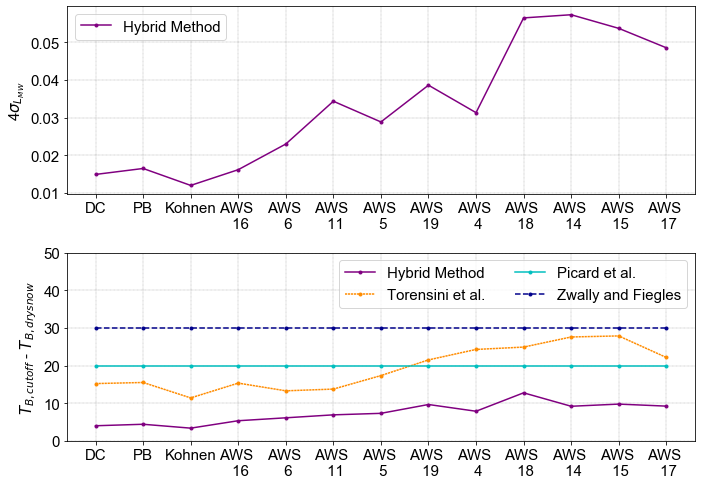

In [160]:
fig,(ax1,ax2,) = plt.subplots(2,1,figsize=(10,7))
ds = []
dsgs = []
nums = [7, 8, 9, 10, 4, 3, 1, 12, 2, 0, 5, 11, 6]

import matplotlib
import scipy.stats
font = {'size'   : 15}

matplotlib.rc('font', **font)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']


locname = ['DC', 'PB', 'Kohnen','AWS \n 16','AWS \n 6','AWS \n 11','AWS \n 5','AWS \n 19','AWS \n 4','AWS \n 18','AWS \n 14','AWS \n 15','AWS \n 17']

tbcutoff=[]
tbcutoffP=[]
tbcutoffZF=[]
tbcutoffT=[]
for num in nums: 
    
    dataH=pickle.load(open('OutputHybrid/FinalTesting/Site'+str(num)+'_18H.p','rb'))

    days = dataH['days']
    tbh_modeled = dataH['TB']
    difference_gs = dataH['y']-dataH['y_down_redone']
    difference = dataH['TB_down']-tbh_modeled
    dsgs.append(np.nanmean(difference_gs))
    ds.append(np.nanmean(difference))
    tbcutoff.append(np.nanmean(tbh_modeled))
    tbcutoffP.append(np.nanmean(dataH['thresholdP']))
    tbcutoffZF.append(np.nanmean(dataH['thresholdZF']))
    tbcutoffT.append(np.nanmean(dataH['thresholdT']))

ax1.plot(locname,np.asarray(dsgs)*10**3,'.-',color='purple',label='Hybrid Method')
ax1.legend()
ax2.plot(locname,ds,'.-',color='purple',label='Hybrid Method')
line1,=ax2.plot(locname,sigmas,'.-',color='darkorange',label='Torensini et al.')
line1.set_dashes([1.5, 0.5, 1.5, 0.5])
valuesP=np.asarray(nums)*0.+20.
valuesZF = np.asarray(nums)*0.+30.
ax2.plot(locname,valuesP,'c.-',label='Picard et al.')
ax2.plot(locname,valuesZF,'.--',color='darkblue',label='Zwally and Fiegles')
ax2.legend(ncol=2)
ax2.set_ylim(0,50)




    
ax1.set_ylabel('4$\sigma_{L_{MW}}$')
ax2.set_ylabel('$T_{B,cut off}$ - $T_{B,dry snow}$')


for ax in [ax1,ax2]:
    ax.grid(which='minor',axis='both', linestyle=':', linewidth='0.3', color='black')
    #     ax.grid(which='major',axis='y', linestyle=':', linewidth='0.8', color='black')
    ax.grid(which='major',axis='both', linestyle=':', linewidth='0.3', color='black')
    
plt.tight_layout()

plt.savefig('Hybrid_Method_Cutoff.png',dpi=300)




In [8]:
def forward_calcV(grain_guess,estimate_tb,thickness,temperature,density,liquid,freq,dense_snow=True):

    snowpack2 = make_snowpack(thickness,"exponential", density = density, temperature = temperature,corr_length = grain_guess,liquid_water=liquid)
    if dense_snow == True:
        m = make_model("iba", "dort",emmodel_options=dict(dense_snow_correction="auto"))
    else:
        m = make_model("iba","dort")
    sensorV = sensor_list.amsr2(freq+'V')
    resV = m.run(sensorV, snowpack2)
#     print('18H brightness temp ',resH.TbH())
    difference = resV.TbV()-estimate_tb
    return resV.TbV(),difference





In [10]:
def forward_calcH(grain_guess,estimate_tb,thickness,temperature,density,liquid,freq,dense_snow=True):

    snowpack2 = make_snowpack(thickness,"exponential", density = density, temperature = temperature,corr_length = grain_guess,liquid_water=liquid)
    if dense_snow == True:
        m = make_model("iba", "dort",emmodel_options=dict(dense_snow_correction="auto"))
    else:
        m = make_model("iba","dort")
    sensorH = sensor_list.amsr2(freq+'H')
    resH = m.run(sensorH, snowpack2)
#     print('18H brightness temp ',resH.TbH())
    difference = resH.TbH()-estimate_tb
    return resH.TbH(),difference

In [18]:

percentage = np.arange(-0.5,0.51,0.05)
TBH_d = np.zeros(percentage.shape)*np.nan
TBV_d = np.zeros(percentage.shape)*np.nan

corr_len = 0.25e-3



for ind,percent in enumerate(percentage):
    TBH_d[ind],xx = forward_calcH(corr_len,np.asarray(250.),thickness_CFM,temperature_CFM,density_CFM+(917-density_CFM)*percent,0,'18',dense_snow=True)
    TBV_d[ind],xx = forward_calcV(corr_len,np.asarray(250.),thickness_CFM,temperature_CFM,density_CFM+(917-density_CFM)*percent,0,'18',dense_snow=True)
    


In [19]:
grain_guesses = np.arange(0.02,0.752,.04)*10**-3
TBH = np.zeros(grain_guesses.shape)*np.nan
TBV = np.zeros(grain_guesses.shape)*np.nan




for ind,grain_guess in enumerate(grain_guesses):
    grains=thickness_CFM.copy()*0+ grain_guess

    TBH[ind],xx = forward_calcH(grains,np.asarray(250.),thickness_CFM,temperature_CFM,density_CFM,0,'18',dense_snow=True)
    TBV[ind],xx = forward_calcV(grains,np.asarray(250.),thickness_CFM,temperature_CFM,density_CFM,0,'18',dense_snow=True)
    


/Users/mdattler/smrt/smrt/rtsolver/dort.py:513: SMRTWarning: DORT has detected that the snowpack is optically shallow (tau=4.76078) and no substrate has been set, meaning that the space under the snowpack is vaccum and that the snowpack is shallow enough to affect the signal measured at the surface.This is usually not wanted. Either increase the thickness of the snowpack or set a substrate. If wanted, add a transparent substrate to supress this warning

To disable all smrt warnings, use: import warnings;
warnings.filterwarnings("ignore", smrt.error.SMRTWarning). See the warnings Python documentation for finer
controls.


  " If wanted, add a transparent substrate to supress this warning" % optical_depth)


In [20]:
import matplotlib
font = {'size'   : 17}

matplotlib.rc('font', **font)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [13]:
grain_guesses_G = np.arange(0.02,0.752,.02)*10**-3
TBH_G_sample = np.zeros(grain_guesses_G.shape)*np.nan
TBV_G_sample = np.zeros(grain_guesses_G.shape)*np.nan

density = 375
import time

t0 = time.time()




for ind,grain_guess in enumerate(grain_guesses_G):
    TBH_G_sample[ind],xx = forward_calcH([grain_guess],np.asarray(250.),[10000.],[255],[density],[0],'18',dense_snow=True)
    TBV_G_sample[ind],xx = forward_calcV([grain_guess],np.asarray(250.),[10000.],[255],[density],[0],'18',dense_snow=True)
    


In [ ]:
densies = np.arange(200,875,5)
TBV_d_sample = np.zeros(densies.shape)*np.nan
TBH_d_sample = np.zeros(densies.shape)*np.nan


corr_len = 0.25e-3
temperature_set = 240.


for ind,dens in enumerate(densies):

    TBV_d_sample[ind],xx=forward_calcV([corr_len],np.asarray(250.),[1000.],[temperature_set],[dens],0,'18',dense_snow=True)
    TBH_d_sample[ind],xx=forward_calcH([corr_len],np.asarray(250.),[1000.],[temperature_set],[dens],0,'18',dense_snow=True)


In [15]:
temperatures_select = np.arange(235,273.15,1)
TBV_t_sample = np.zeros(temperatures_select.shape)*np.nan
TBH_t_sample = np.zeros(temperatures_select.shape)*np.nan


corr_len = 0.25e-3
temperature_set = 240.
density = 375 


for ind,temps_select in enumerate(temperatures_select):
    TBV_t_sample[ind],xx=forward_calcV([corr_len],np.asarray(250.),[1000.],[temps_select],[density],0,'18',dense_snow=True)
    TBH_t_sample[ind],xx=forward_calcH([corr_len],np.asarray(250.),[1000.],[temps_select],[density],0,'18',dense_snow=True)

    

In [16]:
temp_pert = np.arange(-30,31,5)
TBH_t = np.zeros(temp_pert.shape)*np.nan
TBV_t = np.zeros(temp_pert.shape)*np.nan


corr_len = 0.25e-3
temperature_set = 240.


for ind,temp in enumerate(temp_pert):
    TBV_t[ind],xx=forward_calcV(corr_len,np.asarray(250.),thickness_CFM,temperature_CFM+temp,density_CFM,0,'18',dense_snow=True)    
    TBH_t[ind],xx=forward_calcH(corr_len,np.asarray(250.),thickness_CFM,temperature_CFM+temp,density_CFM,0,'18',dense_snow=True)

    
    


In [9]:
# generation snowpack with increasing density from 0 to 916 kg/m3

# grain radius:
# a_s = np.arange(0.1e-3,0.5e-3,0.05e-3)

a = 0.3e-3

density = 500 #np.arange(1, 916, 10)

s = make_snowpack([100000], "exponential", density=density, 
                     temperature=273, 
                     corr_length=a, 
                     liquid_water=0)

layers0 = s.layers[0]
news = s.copy()
if s.layers[0].frac_volume > 0.5:
    news.layers = [s.layers[0].inverted_medium()]
sp = news
    
# layers = [layers0.inverted_medium() if layers0.frac_volume > 0.5 else layers0]


In [10]:
def run(theory, sp, sensor, **kwargs):
    m = make_model(theory, "dort")
    return m.run(sensor, sp)

def forward_calcV_m(grain_guess,estimate_tb,thickness,temperature,density,liquid,freq,method='iba'):
    grain_guesses = [ grain_guess ]

    sp0 = [make_snowpack(thickness,"exponential", density = density, temperature = temperature,corr_length = grain_guess, liquid_water=liquid) for grain_guess in grain_guesses]
    sensor = sensor_list.amsr2(freq+"V")
    layers0 = [s.layers[0] for s in sp0]

    sp = []
    for s in sp0:
        news = s.copy()
        if s.layers[0].frac_volume > 0.5:
            news.layers = [s.layers[0].inverted_medium()]
        sp.append(news)
        
    resV = run(method,sp, sensor)
    difference = resV.TbV()-estimate_tb
    return resV.TbV(),difference



def forward_calcH_m(grain_guess,estimate_tb,thickness,temperature,density,liquid,freq,method='iba'):
    grain_guesses = [ grain_guess ]

    sp0 = [make_snowpack(thickness,"exponential", density = density, temperature = temperature,corr_length = grain_guess, liquid_water=liquid) for grain_guess in grain_guesses]
    sensor = sensor_list.amsr2(freq+"H")
    layers0 = [s.layers[0] for s in sp0]

    sp = []
    for s in sp0:
        news = s.copy()
        if s.layers[0].frac_volume > 0.5:
            news.layers = [s.layers[0].inverted_medium()]
        sp.append(news)
        
    resH = run(method,sp, sensor)
    difference = resH.TbH()-estimate_tb
    return resH.TbH(),difference

